In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/ML4Health/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Machine Learning Applications for Health (COMP90089)
# Assignment 1: Digital Phenopything for Lactic Acidosis using MIMIC-IV data.

<!-- Yizong Xing -- 1160249 -->


## **1. Read the introductory Up To Date [chapter](https://www.uptodate.com/contents/approach-to-the-adult-with-metabolic-acidosis) on Alzheimer Disease**

  ****

## **2. List the criteria used by clinicians to define Dementia / Alzheimer Disease**

###  **2.1. Beta-Amyloid and Tau Proteins**

  Diagnosing Alzheimer's often involves measuring levels of beta-amyloid and tau proteins. These tests can be locate and interpreted:

  * **Beta-Amyloid 42 (Aβ42):**
    * Table: labevents
    * Item ID: Can be found in the d_labitems table corresponding to beta-amyloid.
    * Reference Range: Typically, low levels of Aβ42 (<500 pg/mL in cerebrospinal fluid) are indicative of Alzheimer's disease.
  * **Total Tau (tTau):**
    * Table: labevents
    * Item ID: Located in the d_labitems table for total tau.
    * Reference Range: Elevated levels of tTau (>400 pg/mL in cerebrospinal fluid) suggest neuronal damage, associated with Alzheimer's.

  * **Phosphorylated Tau (pTau):**

    * Table: labevents
    * Item ID: Found in the d_labitems table related to phosphorylated tau.
    * Reference Range: High levels of pTau (>60 pg/mL) are more specific indicators of Alzheimer's disease pathology.

### **2.2. Neuroimaging Tests**
  * **PET Imaging (Positron Emission Tomography):**
    * Table: procedureevents or chartevents
    * Item ID: PET scan itemid can be identified in the d_items table.
    * Characteristic: PET imaging with radioactive tracers (e.g., [18F] Florbetapir) can detect amyloid plaques in the brain. Positive PET scans strongly suggest Alzheimer's disease.
  * **MRI (Magnetic Resonance Imaging):**
    * Table: procedureevents or chartevents
    * Item ID: MRI-related itemid can be found in the d_items table.
    * Characteristic: MRI is used to detect brain atrophy, particularly in the medial temporal lobes, hippocampus, and parietal cortex, which are associated with Alzheimer's disease.

### **2.3. Cerebrospinal Fluid (CSF) Analysis**
  * Table: labevents
  * Item ID: Relevant itemid for CSF analysis can be found in the d_labitems table.
  * Reference Ranges:
    * Low Aβ42: <500 pg/mL
    * Elevated tTau: >400 pg/mL
    * Elevated pTau: >60 pg/mL

### **2.4. Other Laboratory Tests**
To rule out other causes of cognitive impairment, additional lab tests are performed:

  * **Thyroid Function Tests (e.g., TSH levels):**
    * Table: labevents
    * Item ID: Can be found in d_labitems for TSH.
    * Reference Range: TSH should be within 0.4 - 4.0 mIU/L. Abnormal levels may suggest thyroid dysfunction rather than Alzheimer's disease.
  * **Vitamin B12 Levels:**
    * Table: labevents
    * Item ID: Located in d_labitems for Vitamin B12.
    * Reference Range: Normal range is typically 200 - 900 pg/mL. Low levels may be associated with cognitive impairment unrelated to Alzheimer's.

## 3. **ICD Codes of Dementia / Alzheimer Disease**
  
  * **E87.2** - Acidosis (Including lactic and metabolic)

## 4. **Mapping from ICD10 codes to SNOMED-CT codes**

  
  | ICD-10 Code | ICD-10 Description | SNOMED-CT Code | SNOMED-CT Description |
  |----------|----------|----------|----------|
  | G30    | Alzheimer Disease  | 91273001  | Lactic Acidosis (disorder)  |
  |     |    | 51294009  | Metabolic Acidosis   |
  |     |    | 51387008 | Acidosis   |

  


## 5. **Describe algorithm to find the cohort that meet the definition of Lactic Acidosis:**

  Lactic acidosis that lasted > 120 minutes and was corrected after the use of intravenous vasoactive drugs.

#### **An overview**:
The code includes two main parts: one for data filtering and wrangling, and the other one for checking whether the definition is fulfilled.

* **Data filtering and wrangling**
  * Search available test data about lactate and bicarbonate(hco3) from bigquery
  * Load data tables from hosp and icu
  * Load usage of intravenous vasoactive (IV) drugs from emar table, join with prescription table to make sure the input route is "IV"
  * Get intersection of patients that have data in these three tables (lactate, hco3, drugs)
  * Filter data according to the intersection patient list
  * Plot the distribution of data tables to check unreasonable outliers
  * Remove outliers, get final data tables


* **Definition checking**

  An **event** is defined as:
  * **starttime**: Start from an abnormal data that meets one of the criteria of Lactate Acidosis, i.e.:
    * if this data is about a bicarbonate test, it is abnormal if value < 22
    * if this data is about a lactate test, it is abnormal if value > 4.
  
    This data's *charttime* is the **starttime** of the event.
  * Include all the continuous abnormal data while iterating i the table.
  * **endtime**: End with the first **normal** test data. Its *charttime* is the **endtime** of the event.
  * **last_time** & **continue_time**: The *charttime* of the last abnormal data included (i.e. the one before the ending normal data), defined as **last_time**, is at least 120 minutes later than the *charttime* of the starting data. The time difference is the **continuetime** of the event.
  * There is at least one drug administration record's *charttime* lies between the **starttime** and **endtime** (NOT the **last_time**).
  * There is at least one abnormal record for each of the criteria (hco3 and lactate) of this patient. Absense of any one will fail this event. The **flag['hco3']/flag['lact']** is used to record the attendence.

  Detailed algorithm examples and implementations can be found later in the code sessoins.

#### **Assumptions:**

*


## Load libraries and setup environment

In [ ]:
# Import libraries

!pip install tslearn
!pip install minisom
!pip install dtw-python
!pip install Levenshtein


from tslearn.metrics import cdist_dtw
from sklearn.cluster import AgglomerativeClustering
from minisom import MiniSom
from dtw import dtw

from datetime import timedelta
import os

import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

import bigframes.pandas as bf
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
pio.renderers.default = "colab"

from gensim.models import Word2Vec

from IPython.display import clear_output

import torch

import copy
import datetime
import sys

bf.options.bigquery.location = "US"
bf.options.bigquery.project = 'hellobigquery-431508'


In [ ]:
# authenticate
auth.authenticate_user()

# Set up environment variables
project_id = 'hellobigquery-431508'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id
dataset = 'mimiciv'


## **Find patients with AD related ICD codes.**

Load all diagnoses icd table, and filter with our event list:

In [ ]:
query = """
  SELECT
    d.*,
    a.dischtime AS discharge_time
  FROM
    `physionet-data.mimiciv_hosp.diagnoses_icd` AS d
  INNER JOIN
    `physionet-data.mimiciv_hosp.admissions` AS a
  ON
    d.hadm_id = a.hadm_id
  WHERE
    d.icd_code IN ('G300', 'G301', 'G308', 'G309', 'F0280', 'F0281', 'F0290', 'F0391', 'F04',
      'F060', 'F068', 'G3101', 'G3109', 'G311', 'G3183', 'G3185', 'G3189', 'G319',
      'G454', 'G937', 'G94', 'G910', 'G911', 'G912', 'F0150', 'F0151', 'I675',
      'I671', 'I672', 'I674', 'I676', 'I677', 'I6781', 'I6782', 'I6789', 'I679')

"""
df_ad_patients_with_discharge_time = bf.read_gbq(query)
print(len(df_ad_patients_with_discharge_time))
df_ad_patients_with_discharge_time.head(10)

# WHERE
    # d.icd_code IN ('G300', 'G301', 'G308', 'G309', 'F0280', 'F0281', 'F0290', 'F0391', 'F04',
    # 'F060', 'F068', 'G3101', 'G3109', 'G311', 'G3183', 'G3185', 'G3189', 'G319',
    # 'G454', 'G937', 'G94', 'G910', 'G911', 'G912', 'F0150', 'F0151', 'I675',
    # 'I671', 'I672', 'I674', 'I676', 'I677', 'I6781', 'I6782', 'I6789', 'I679',
    # '29012', '331', '2904', '29041', '29042', '29043', '294', '2948', '2949',
    # '2941', '29411', '2942', '29421', '3312', '3316', '3317', '33111', '33119',
    # '33181', '33182', '33189', '4377', '3313', '3314', '3315', '437', '4371',
    # '4372', '4373', '4374', '4375', '4376', '4378', '4379', '33183', '331',
    # '3311' )

7420


subject_id   hadm_id  seq_num icd_code  icd_version       discharge_time
0    17933761  20476026        4    F0280           10  2112-11-08 12:20:00
1    14945936  26868663        5    F0391           10  2203-05-28 15:32:00
2    19865666  27925490       13    F0280           10  2152-05-14 16:57:00
3    10707442  23962945        4    F0280           10  2147-06-21 14:38:00
4    19021878  20406937        9    F0280           10  2173-02-22 13:33:00
5    12864680  21022399       14    G3183           10  2144-10-11 15:02:00
6    15380556  27064881        1     I671           10  2141-08-30 15:45:00
7    14125217  22678449       10     I672           10  2182-06-27 15:30:00
8    19454731  23586324        3     I671           10  2134-08-02 17:50:00
9    18497825  23119353       14    F0280           10  2177-01-02 11:15:00

[10 rows x 6 columns]

In [ ]:
# df_ad_patients_with_discharge_time.head(10)

In [ ]:
ad_patients_list = list(df_ad_patients_with_discharge_time.drop_duplicates(subset=['subject_id'])['subject_id'])
len(ad_patients_list)
# df_ad_patients

3947

## Possible Tests

## **See what tests are taken by these patients**

In [ ]:
# See what labtests are taken for these patients

query = """
  SELECT
    d.subject_id,
    d.hadm_id,
    d.icd_code,
    d.icd_version,
    l.itemid,
    l.valuenum,
    l.valueuom,
    l.labevent_id,
    l.charttime,
    l.flag,
    dlab.label,
    dlab.fluid,
    dlab.category
  FROM
    (
      SELECT subject_id, hadm_id, icd_code, icd_version
      FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
      WHERE icd_code IN ('G300', 'G301', 'G308', 'G309', 'F0280', 'F0281', 'F0290', 'F0391', 'F04',
            'F060', 'F068', 'G3101', 'G3109', 'G311', 'G3183', 'G3185', 'G3189', 'G319',
            'G454', 'G937', 'G94', 'G910', 'G911', 'G912', 'F0150', 'F0151', 'I675',
            'I671', 'I672', 'I674', 'I676', 'I677', 'I6781', 'I6782', 'I6789', 'I679')
    ) AS d
  INNER JOIN
    (
      SELECT subject_id, hadm_id, labevent_id, itemid, valuenum, valueuom, charttime, flag
      FROM `physionet-data.mimiciv_hosp.labevents`
      WHERE lower(flag) LIKE 'abnormal%'
        OR flag IS NULL
    ) AS l
  ON
    d.subject_id = l.subject_id
    AND d.hadm_id = l.hadm_id
  INNER JOIN
    `physionet-data.mimiciv_hosp.d_labitems` AS dlab
  ON
    l.itemid = dlab.itemid
    WHERE l.valuenum IS NOT NULL  -- remove NULL values
  # WHERE (LOWER(dlab.label) LIKE '%csf' OR
  #  LOWER(dlab.label) LIKE'%b12%')
"""
df_ad_patients_lab_results = bf.read_gbq(query).sort_values(by=['subject_id', 'charttime', 'labevent_id']).reset_index(drop=True)
print(len(df_ad_patients_lab_results))
df_ad_patients_lab_results.head(10)


1385974


subject_id   hadm_id icd_code  icd_version  itemid  valuenum valueuom  \
0    10000084  23052089    F0280           10   51133      2.86     K/uL   
1    10000084  23052089    G3183           10   51133      2.86     K/uL   
2    10000084  23052089    F0280           10   51146       0.6        %   
3    10000084  23052089    G3183           10   51146       0.6        %   
4    10000084  23052089    G3183           10   51200       2.0        %   
5    10000084  23052089    F0280           10   51200       2.0        %   
6    10000084  23052089    G3183           10   51221      38.2        %   
7    10000084  23052089    F0280           10   51221      38.2        %   
8    10000084  23052089    G3183           10   51222      12.8     g/dL   
9    10000084  23052089    F0280           10   51222      12.8     g/dL   

   labevent_id            charttime      flag                      label  \
0          672  2160-11-20 22:30:00      <NA>  Absolute Lymphocyte Count   
1          672  2160-11-20 22:30:00      <NA>  Absolute Lymphocyte Count   
2          673  2160-11-20 22:30:00      <NA>                  Basophils   
3          673  2160-11-20 22:30:00      <NA>                  Basophils   
4          674  2160-11-20 22:30:00      <NA>                Eosinophils   
5          674  2160-11-20 22:30:00      <NA>                Eosinophils   
6          675  2160-11-20 22:30:00  abnormal                 Hematocrit   
7          675  2160-11-20 22:30:00  abnormal                 Hematocrit   
8          676  2160-11-20 22:30:00  abnormal                 Hemoglobin   
9          676  2160-11-20 22:30:00  abnormal                 Hemoglobin   

   fluid    category  
0  Blood  Hematology  
1  Blood  Hematology  
2  Blood  Hematology  
3  Blood  Hematology  
4  Blood  Hematology  
5  Blood  Hematology  
6  Blood  Hematology  
7  Blood  Hematology  
8  Blood  Hematology  
9  Blood  Hematology  

[10 rows x 13 columns]

For each patient, only keep the test data with charttime before their diagnoses' dischargetime

In [ ]:
df_temp = df_ad_patients_with_discharge_time[['subject_id', 'hadm_id', 'discharge_time']].drop_duplicates(subset=['subject_id', 'hadm_id']).to_pandas()
df_ad_patients_lab_results_pd = df_ad_patients_lab_results.to_pandas()

df_ad_patients_lab_results_pd = pd.merge(df_ad_patients_lab_results_pd, df_temp, on=['subject_id', 'hadm_id'], how='left')

df_ad_patients_lab_results_pd = df_ad_patients_lab_results_pd[df_ad_patients_lab_results_pd['charttime'] <= df_ad_patients_lab_results_pd['discharge_time']].reset_index(drop=True)

print(len(df_ad_patients_lab_results_pd))
df_ad_patients_lab_results_pd.head(10)


1385218


subject_id   hadm_id icd_code  icd_version  itemid  valuenum valueuom  \
0    10000084  23052089    F0280           10   51133      2.86     K/uL   
1    10000084  23052089    G3183           10   51133      2.86     K/uL   
2    10000084  23052089    F0280           10   51146       0.6        %   
3    10000084  23052089    G3183           10   51146       0.6        %   
4    10000084  23052089    G3183           10   51200       2.0        %   
5    10000084  23052089    F0280           10   51200       2.0        %   
6    10000084  23052089    G3183           10   51221      38.2        %   
7    10000084  23052089    F0280           10   51221      38.2        %   
8    10000084  23052089    G3183           10   51222      12.8     g/dL   
9    10000084  23052089    F0280           10   51222      12.8     g/dL   

   labevent_id            charttime      flag                      label  \
0          672  2160-11-20 22:30:00      <NA>  Absolute Lymphocyte Count   
1          672  2160-11-20 22:30:00      <NA>  Absolute Lymphocyte Count   
2          673  2160-11-20 22:30:00      <NA>                  Basophils   
3          673  2160-11-20 22:30:00      <NA>                  Basophils   
4          674  2160-11-20 22:30:00      <NA>                Eosinophils   
5          674  2160-11-20 22:30:00      <NA>                Eosinophils   
6          675  2160-11-20 22:30:00  abnormal                 Hematocrit   
7          675  2160-11-20 22:30:00  abnormal                 Hematocrit   
8          676  2160-11-20 22:30:00  abnormal                 Hemoglobin   
9          676  2160-11-20 22:30:00  abnormal                 Hemoglobin   

   fluid    category       discharge_time  
0  Blood  Hematology  2160-11-25 14:52:00  
1  Blood  Hematology  2160-11-25 14:52:00  
2  Blood  Hematology  2160-11-25 14:52:00  
3  Blood  Hematology  2160-11-25 14:52:00  
4  Blood  Hematology  2160-11-25 14:52:00  
5  Blood  Hematology  2160-11-25 14:52:00  
6  Blood  Hematology  2160-11-25 14:52:00  
7  Blood  Hematology  2160-11-25 14:52:00  
8  Blood  Hematology  2160-11-25 14:52:00  
9  Blood  Hematology  2160-11-25 14:52:00

In [ ]:
df_ad_patients_lab_results_pd = df_ad_patients_lab_results.to_pandas()
df_ad_patients_lab_results_pd['itemid'] = df_ad_patients_lab_results_pd['itemid'].astype(str)
df_ad_patients_lab_results_pd.dtypes

subject_id                      Int64
hadm_id                         Int64
icd_code              string[pyarrow]
icd_version                     Int64
itemid                         object
valuenum                      Float64
valueuom              string[pyarrow]
labevent_id                     Int64
charttime      timestamp[us][pyarrow]
flag                  string[pyarrow]
label                 string[pyarrow]
fluid                 string[pyarrow]
category              string[pyarrow]
dtype: object

In [ ]:
# see how many unique patients:
print(len(df_ad_patients_lab_results_pd['subject_id'].unique()))

3764


In [ ]:
possible_tests = bf.read_gbq("""
  SELECT *
  FROM `physionet-data.mimiciv_hosp.d_labitems`
""")
ad_tests = list(set(df_ad_patients_lab_results['itemid']))
ad_test_names = possible_tests[possible_tests['itemid'].isin(ad_tests)].to_pandas()
ad_test_names['itemid'] = ad_test_names['itemid'].astype(str)

ad_test_names.head(1)

itemid      label  fluid    category
5  51203  Factor IX  Blood  Hematology

In [ ]:
itemid_counts_df = df_ad_patients_lab_results_pd.groupby('itemid')['subject_id'].nunique().reset_index()
itemid_counts_df.columns = ['itemid', 'count']
itemid_counts_df['itemid'] = itemid_counts_df['itemid'].astype(str)


merged_df = pd.merge(itemid_counts_df, ad_test_names, on='itemid', how='inner')

merged_df_sorted = merged_df.sort_values(by='count', ascending=False)

merged_df_sorted

itemid  count                    label    fluid    category
70   50912   3729               Creatinine    Blood   Chemistry
130  51006   3728            Urea Nitrogen    Blood   Chemistry
107  50971   3727                Potassium    Blood   Chemistry
60   50902   3722                 Chloride    Blood   Chemistry
46   50882   3722              Bicarbonate    Blood   Chemistry
..     ...    ...                      ...      ...         ...
377  52129      1         Hemoglobin Other    Blood  Hematology
352  51772      1                     PAN3    Blood   Chemistry
33   50850      1   Triglycerides, Ascites  Ascites   Chemistry
156  51072      1           Amylase, Urine    Urine   Chemistry
378  52132      1  HIT-Ab Numerical Result    Blood  Hematology

[406 rows x 5 columns]

### **Apply Word2vec embedding, treating each patient's test history as a "sentence" and each labtest as a "word".**

Prepare the sentences:

In [ ]:
query = """
    SELECT
        subject_id,
        STRING_AGG(CAST(itemid AS STRING) ORDER BY charttime ASC) AS itemid_sequence,  -- ASC for time order
        ARRAY_AGG(CAST(valuenum AS FLOAT64) ORDER BY charttime ASC) AS test_value_sequence,  -- ASC for time order
        ARRAY_LENGTH(ARRAY_AGG(itemid ORDER BY charttime ASC)) AS sequence_length,
        STRING_AGG(DISTINCT icd_code ORDER BY icd_code ASC) AS icd_codes,
        'mimic_iv' AS data_source,  -- New column with constant value 'mimic_iv'
        CASE
            WHEN REGEXP_CONTAINS(STRING_AGG(DISTINCT icd_code ORDER BY icd_code ASC), r'G30.*')
            THEN 1
            ELSE 0
        END AS label_ad  -- New column that marks Alzheimer's Disease based on G30 ICD codes
    FROM (
        SELECT
            d.subject_id,
            l.itemid,
            l.valuenum,
            l.charttime,
            d.icd_code,
        FROM
            physionet-data.mimiciv_hosp.diagnoses_icd AS d
        JOIN
            physionet-data.mimiciv_hosp.labevents AS l
        ON
            d.subject_id = l.subject_id
        JOIN
            physionet-data.mimiciv_hosp.admissions AS a
        ON
            l.hadm_id = a.hadm_id
        INNER JOIN
          `physionet-data.mimiciv_hosp.d_labitems` AS dlab
        ON
          l.itemid = dlab.itemid
        WHERE
            d.icd_code IN ('G300', 'G301', 'G308', 'G309', 'F0280', 'F0281', 'F0290', 'F0391', 'F04',
                'F060', 'F068', 'G3101', 'G3109', 'G311', 'G3183', 'G3185', 'G3189', 'G319',
                'G454', 'G937', 'G94', 'G910', 'G911', 'G912', 'F0150', 'F0151', 'I675',
                'I671', 'I672', 'I674', 'I676', 'I677', 'I6781', 'I6782', 'I6789', 'I679')
            AND l.valuenum IS NOT NULL
            AND l.charttime <= a.dischtime
            AND (LOWER(l.flag) LIKE 'abnormal%' OR l.flag IS NULL)
            AND LOWER(dlab.label) NOT LIKE '%csf'
    ) AS filtered

    GROUP BY
        subject_id
    ORDER BY
        subject_id;
"""




df_itemid_sequences_4 = bf.read_gbq(query)
print(len(df_itemid_sequences_4))
df_itemid_sequences_4.head(10)


3871


subject_id                                    itemid_sequence  \
0    16660864  51146,51222,51244,51301,50947,51249,52172,5167...   
1    14995040  51250,51250,51250,51250,51257,51257,51257,5125...   
2    12492723  51244,51254,52069,51222,51275,50868,50902,5113...   
3    18504807  50882,51006,50931,50971,50902,50868,50970,5091...   
4    17528912  51277,51250,50902,51249,50868,50912,51244,5092...   
5    11400855  51222,51222,51006,51006,51277,51277,51221,5122...   
6    18449692  52009,52010,52007,52008,52004,52005,52006,5094...   
7    17624727  51222,51249,51248,51279,52172,51265,51221,5125...   
8    10430393  51222,50902,50868,51006,50893,51248,51274,5097...   
9    19616427  51301,51301,50882,50882,51248,51248,50983,5098...   

                                 test_value_sequence  sequence_length  \
0  [ 3.00e-01  1.42e+01  2.18e+01  5.90e+00  1.00...              172   
1  [9.20e+01 9.20e+01 9.20e+01 9.20e+01 2.00e-01 ...              240   
2  [3.84e+01 7.40e+00 6.00e-02 1.25e+01 3.18e+01 ...               45   
3  [ 24.    19.    94.     4.7  104.    15.     4...               39   
4    [ 17.    96.   102.   ...  43.     7.16 -14.  ]             1368   
5  [ 10.6   10.6   22.    22.    15.    15.    34...              156   
6  [-7.100e+01 -3.660e+02 -4.520e+02 -2.570e+02 -...              620   
7  [  9.2   31.8   26.4    3.48  47.9  283.    28...               83   
8  [1.120e+01 1.010e+02 1.300e+01 1.800e+01 8.800...              224   
9  [1.050e+01 1.050e+01 3.100e+01 3.100e+01 3.120...              288   

    icd_codes data_source  label_ad  
0        I672    mimic_iv         0  
1  F0280,G309    mimic_iv         1  
2        I671    mimic_iv         0  
3        I675    mimic_iv         0  
4         F04    mimic_iv         0  
5  F0280,G309    mimic_iv         1  
6        I671    mimic_iv         0  
7        G912    mimic_iv         0  
8        I671    mimic_iv         0  
9  F0280,G309    mimic_iv         1  

[10 rows x 7 columns]

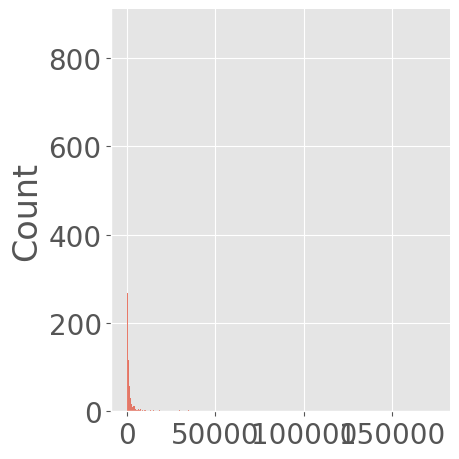

In [ ]:
# prompt: plot distribution of df_itemid_sequences['sequence_length']
df_labtest_sequences_pd_4 = df_itemid_sequences_4.to_pandas()
sns.displot(df_itemid_sequences_4['sequence_length'])


In [ ]:
print(df_itemid_sequences_4['sequence_length'].max())
print(df_itemid_sequences_4['sequence_length'].min())

174003


2


In [ ]:
print(df_itemid_sequences_4.dtypes)

subject_id                                   Int64
itemid_sequence                    string[pyarrow]
test_value_sequence    list<item: double>[pyarrow]
sequence_length                              Int64
icd_codes                          string[pyarrow]
data_source                        string[pyarrow]
label_ad                                     Int64
dtype: object


### **Similarly for MIMIC_III**

In [ ]:
query = """
    SELECT
        subject_id,
        STRING_AGG(CAST(itemid AS STRING) ORDER BY charttime ASC) AS itemid_sequence,  -- ASC for time order
        ARRAY_AGG(CAST(valuenum AS FLOAT64) ORDER BY charttime ASC) AS test_value_sequence,  -- ASC for time order
        ARRAY_LENGTH(ARRAY_AGG(itemid ORDER BY charttime ASC)) AS sequence_length,
        STRING_AGG(DISTINCT icd9_code ORDER BY icd9_code ASC) AS icd_codes,
        'mimic_iii' AS data_source,
        CASE WHEN STRING_AGG(DISTINCT icd9_code ORDER BY icd9_code ASC) LIKE '%331%' THEN 1 ELSE 0 END AS label_ad
    FROM (
        SELECT
            d.subject_id,
            l.itemid,
            l.valuenum,
            l.charttime,
            d.icd9_code,
        FROM
            `physionet-data.mimiciii_clinical.diagnoses_icd` AS d
        JOIN
            `physionet-data.mimiciii_clinical.labevents` AS l
        ON
            d.subject_id = l.subject_id
        JOIN
            `physionet-data.mimiciii_clinical.admissions` AS a
        ON
            l.hadm_id = a.hadm_id
        INNER JOIN
          `physionet-data.mimiciii_clinical.d_labitems` AS dlab
        ON
          l.itemid = dlab.itemid
        WHERE
            d.icd9_code LIKE '331%'  -- ICD-9 codes for Alzheimer's and related diseases
            AND l.valuenum IS NOT NULL
            AND l.charttime <= a.dischtime

            -- AND (LOWER(l.flag) LIKE 'abnormal%' OR l.flag IS NULL)
            AND (LOWER(l.flag) LIKE 'abnormal%')

            AND LOWER(dlab.label) NOT LIKE '%csf%'
    ) AS filtered

    GROUP BY
        subject_id
    ORDER BY
        subject_id;
"""
df_itemid_sequences_3 = bf.read_gbq(query)
print(len(df_itemid_sequences_3))
df_itemid_sequences_3.head(10)

1246


subject_id                                    itemid_sequence  \
0       73388  50809,50820,50803,51006,50813,51301,50806,5121...   
1       29798  50931,50931,51003,51003,51275,51275,51274,5127...   
2       66492  51221,51006,51222,51279,50912,51244,50931,5125...   
3       89168  51237,51301,51248,51274,51249,51003,50809,5080...   
4       98973  51244,50902,51006,51301,51143,51256,50882,5127...   
5       68941  51256,50931,51200,51244,50813,51301,51000,5090...   
6       89644  51256,50868,50882,51279,51244,50931,51301,5100...   
7       57366  51301,51244,51006,51279,51256,51221,50912,5122...   
8       62042  51279,51222,51254,51255,51256,51277,51301,5127...   
9       78319  50963,51244,51301,50882,50931,51256,50902,5081...   

                                 test_value_sequence  sequence_length  \
0  [1.17e+02 7.32e+00 3.40e+01 2.90e+01 2.80e+00 ...              655   
1  [1.210e+02 1.210e+02 4.000e-02 4.000e-02 1.315...               70   
2  [3.38e+01 2.60e+01 1.18e+01 3.58e+00 1.60e+00 ...              149   
3  [1.20e+00 1.94e+01 3.21e+01 1.35e+01 3.52e+01 ...              402   
4  [4.000e+00 9.100e+01 2.200e+01 1.400e+01 3.000...              383   
5  [  43.2   106.      4.9    45.4     2.6    12....               73   
6  [ 36.9   24.    20.     4.5   56.5  125.    14...               26   
7  [2.64e+01 2.00e+00 5.00e+01 4.33e+00 9.20e+01 ...               86   
8  [  3.25  10.     1.     1.    89.    19.4   24...               57   
9  [4.825e+03 5.800e+00 1.470e+01 3.300e+01 1.430...               77   

   icd_codes data_source  label_ad  
0      33119   mimic_iii         1  
1  3310,3313   mimic_iii         1  
2       3310   mimic_iii         1  
3       3314   mimic_iii         1  
4       3310   mimic_iii         1  
5       3314   mimic_iii         1  
6       3310   mimic_iii         1  
7       3310   mimic_iii         1  
8       3314   mimic_iii         1  
9       3310   mimic_iii         1  

[10 rows x 7 columns]

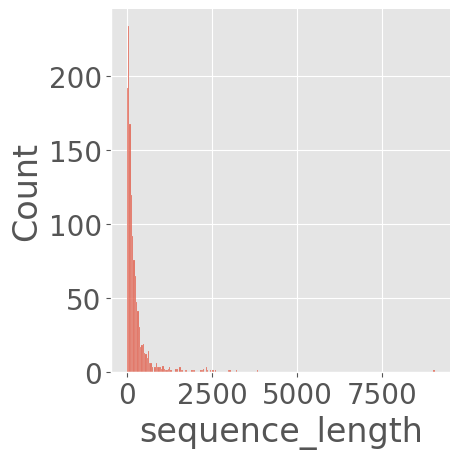

In [ ]:
df_labtest_sequences_pd_3 = df_itemid_sequences_3.to_pandas()
sns.displot(df_labtest_sequences_pd_3['sequence_length'])

In [ ]:
print(df_labtest_sequences_pd_3.head())

   subject_id                                    itemid_sequence  \
0       73388  50809,50820,50803,51006,50813,51301,50806,5121...   
1       29798  50931,50931,51003,51003,51275,51275,51274,5127...   
2       66492  51221,51006,51222,51279,50912,51244,50931,5125...   
3       89168  51237,51301,51248,51274,51249,51003,50809,5080...   
4       98973  51244,50902,51006,51301,51143,51256,50882,5127...   

                                 test_value_sequence  sequence_length  \
0  [1.17e+02 7.32e+00 3.40e+01 2.90e+01 2.80e+00 ...              655   
1  [1.210e+02 1.210e+02 4.000e-02 4.000e-02 1.315...               70   
2  [3.38e+01 2.60e+01 1.18e+01 3.58e+00 1.60e+00 ...              149   
3  [1.20e+00 1.94e+01 3.21e+01 1.35e+01 3.52e+01 ...              402   
4  [4.000e+00 9.100e+01 2.200e+01 1.400e+01 3.000...              383   

   icd_codes data_source  label_ad  
0      33119   mimic_iii         1  
1  3310,3313   mimic_iii         1  
2       3310   mimic_iii         1  
3   

**Combine data from mimic iii and iv**

Skewness: 20.071738351234906
Number of outliers: 598


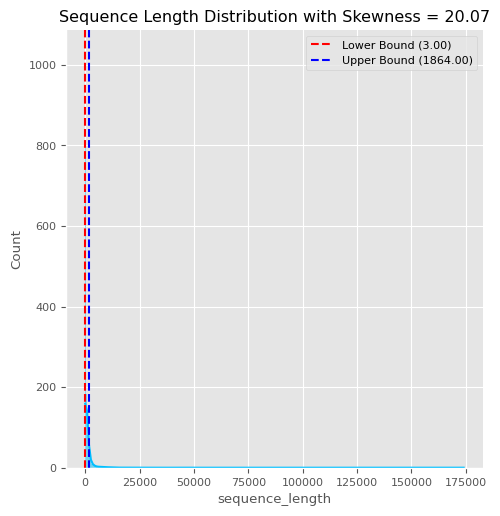

In [ ]:
# df_labtest_sequences_pd = df_itemid_sequences.to_pandas()
df_labtest_sequences_pd = pd.concat([df_labtest_sequences_pd_4, df_labtest_sequences_pd_3], ignore_index=True)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams.update({'font.size': 8})

sns.displot(df_labtest_sequences_pd['sequence_length'], kde=True, color='#00BFFF')

skewness = df_labtest_sequences_pd['sequence_length'].skew()
print(f'Skewness: {skewness}')

plt.title(f'Sequence Length Distribution with Skewness = {skewness:.2f}')

# IQR for detecting outliers
Q1 = df_labtest_sequences_pd['sequence_length'].quantile(0.25)
Q3 = df_labtest_sequences_pd['sequence_length'].quantile(0.75)
IQR = Q3 - Q1

# for outliers
lower_bound = max(Q1 - 1.5 * IQR , 3)
upper_bound = Q3 + 1.5 * IQR

outliers = df_labtest_sequences_pd[(df_labtest_sequences_pd['sequence_length'] < lower_bound) |
                   (df_labtest_sequences_pd['sequence_length'] > upper_bound)]

print(f"Number of outliers: {len(outliers)}")

# sns.histplot(data, kde=True)
plt.axvline(x=lower_bound, color='r', linestyle='--', label=f'Lower Bound ({lower_bound:.2f})')
plt.axvline(x=upper_bound, color='b', linestyle='--', label=f'Upper Bound ({upper_bound:.2f})')
plt.legend()
plt.show()


**Split itemid sequences, save dataframe**

In [ ]:
import ast


df_labtest_sequences_pd['itemid_sequence'] = df_labtest_sequences_pd['itemid_sequence'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
# df_labtest_sequences_pd['test_value_sequence'] = df_labtest_sequences_pd['test_value_sequence'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
df_labtest_sequences_pd.to_csv(file_path + 'df_labtest_sequences_pd.csv', index=False)

patients_itemid_seqs = df_labtest_sequences_pd['itemid_sequence']
patients_itemid_seqs[:1]

0    [51146, 51222, 51244, 51301, 50947, 51249, 521...
Name: itemid_sequence, dtype: object

In [ ]:
# df_labtest_sequences_pd = pd.read_csv('df_labtest_sequences_pd.csv')
print(len(df_labtest_sequences_pd))
df_labtest_sequences_pd.head(1)

5117


subject_id                                    itemid_sequence  \
0    16660864  [51146, 51222, 51244, 51301, 50947, 51249, 521...   

                                 test_value_sequence  sequence_length  \
0  [ 3.00e-01  1.42e+01  2.18e+01  5.90e+00  1.00...              172   

  icd_codes data_source  label_ad  
0      I672    mimic_iv         0

# **Plot distributions**

In [ ]:
df_ad_patients_lab_results_pd.head()

subject_id   hadm_id icd_code  icd_version itemid  valuenum valueuom  \
0    10000084  23052089    F0280           10  51133      2.86     K/uL   
1    10000084  23052089    G3183           10  51133      2.86     K/uL   
2    10000084  23052089    F0280           10  51146       0.6        %   
3    10000084  23052089    G3183           10  51146       0.6        %   
4    10000084  23052089    G3183           10  51200       2.0        %   

   labevent_id            charttime  flag                      label  fluid  \
0          672  2160-11-20 22:30:00  <NA>  Absolute Lymphocyte Count  Blood   
1          672  2160-11-20 22:30:00  <NA>  Absolute Lymphocyte Count  Blood   
2          673  2160-11-20 22:30:00  <NA>                  Basophils  Blood   
3          673  2160-11-20 22:30:00  <NA>                  Basophils  Blood   
4          674  2160-11-20 22:30:00  <NA>                Eosinophils  Blood   

     category  
0  Hematology  
1  Hematology  
2  Hematology  
3  Hematology  
4  Hematology

**Plot distributions for each labtest itemid based on global data**

Processing itemid 52132 , 406/406 (100.00%)

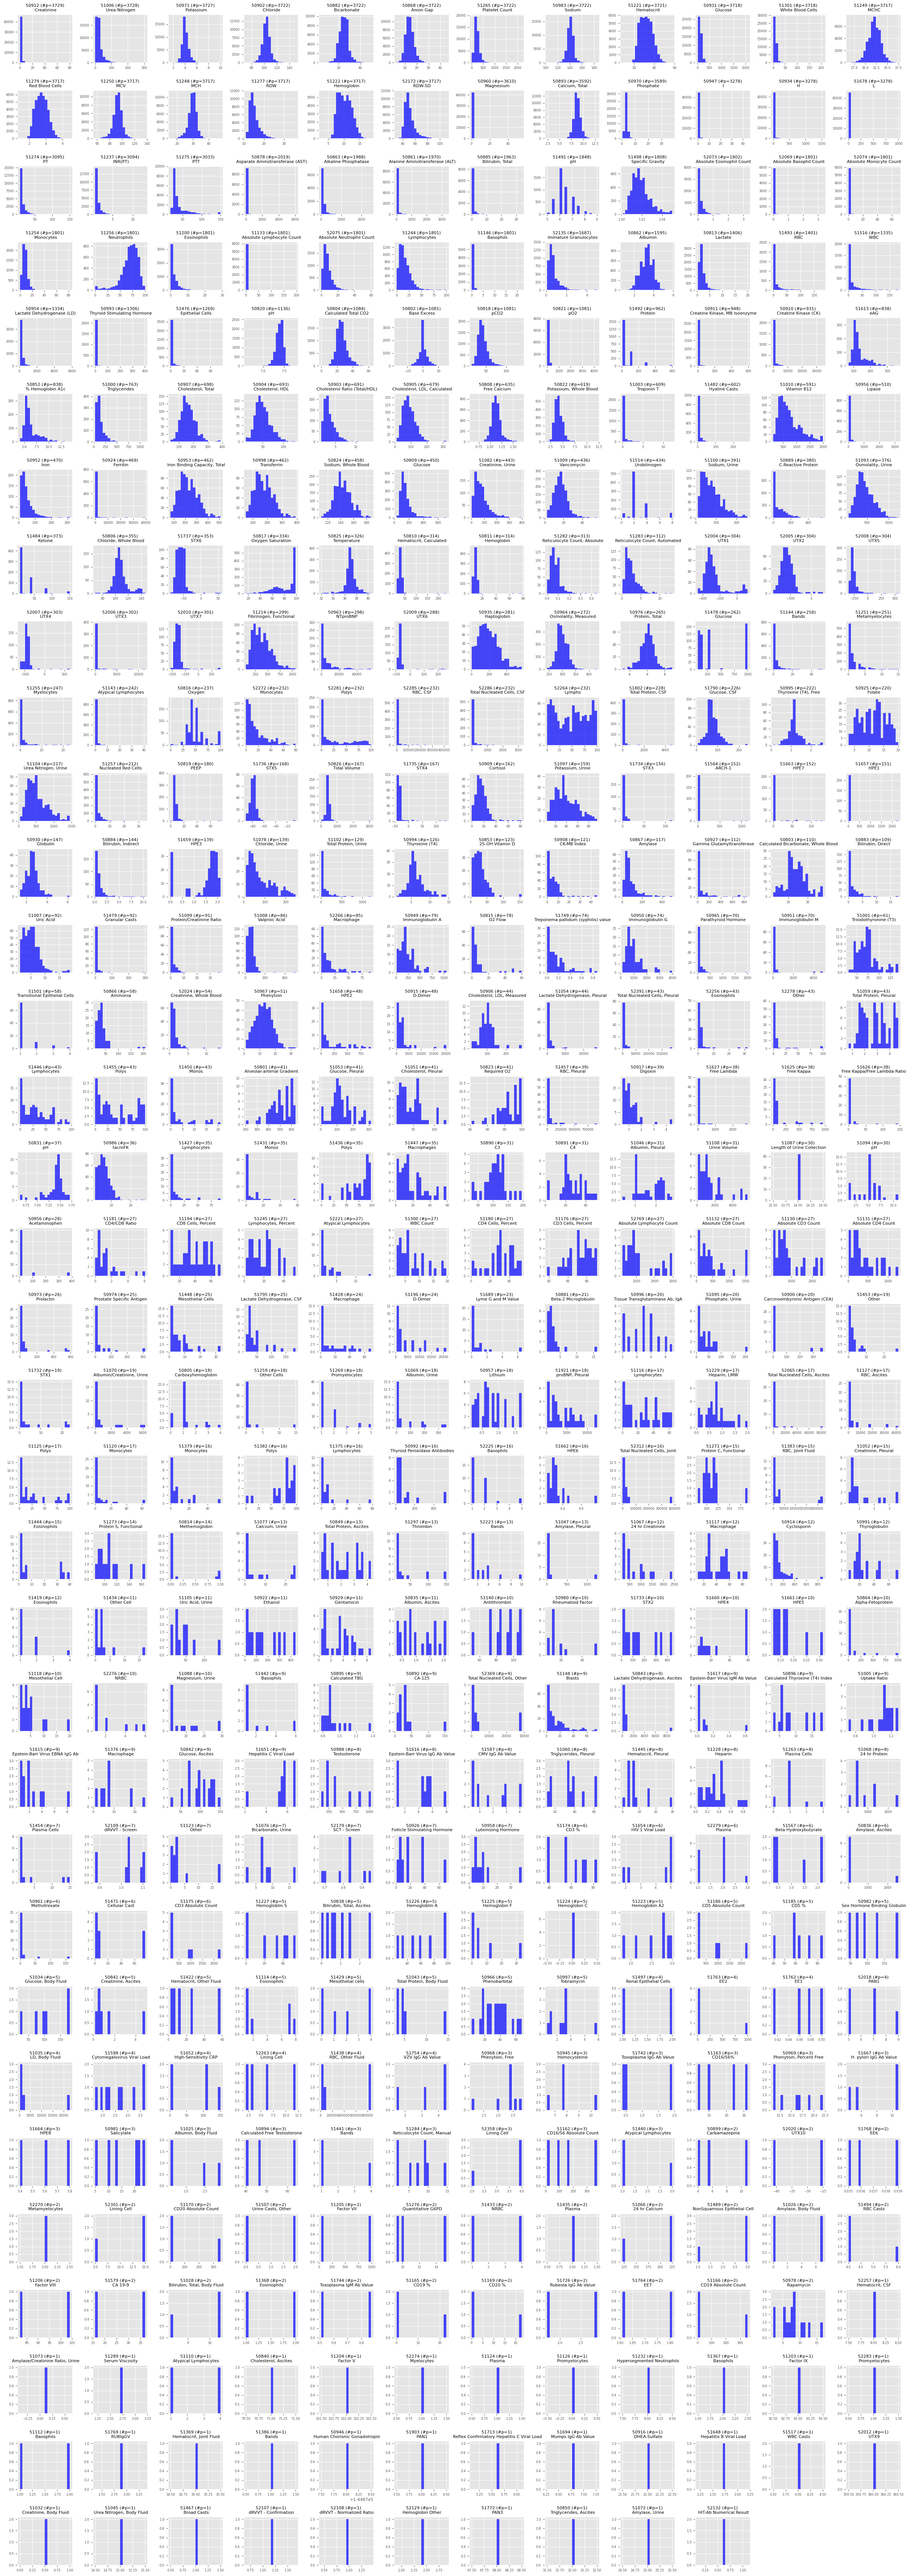

In [ ]:
from sklearn.preprocessing import RobustScaler

unique_itemids = df_ad_patients_lab_results_pd['itemid'].unique()
num_itemids = len(unique_itemids)
itemid_patient_counts = df_ad_patients_lab_results_pd.groupby('itemid')['subject_id'].nunique().sort_values(ascending=False)

sorted_unique_itemids = itemid_patient_counts.index.values
sorted_patient_counts = itemid_patient_counts.values

num_cols = 12
num_rows = (num_itemids + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2), sharex=False, sharey=False)
axes = axes.flatten()

for i in range(num_itemids):
    itemid = sorted_unique_itemids[i]
    patient_count = sorted_patient_counts[i]

    item_values = df_ad_patients_lab_results_pd[df_ad_patients_lab_results_pd['itemid'] == itemid]['valuenum'].dropna()

    sys.stdout.write(f"\rProcessing itemid {itemid} , {i + 1}/{num_itemids} ({(i + 1) / num_itemids * 100:.2f}%)")
    sys.stdout.flush()

    if item_values.empty or item_values.size == 0:
        continue

    axes[i].hist(item_values, bins=20, color='blue', alpha=0.7)
    label = merged_df.loc[merged_df['itemid'] == itemid, 'label'].iloc[0]
    axes[i].set_title(f'{itemid} (#p={patient_count})\n {label}', fontsize=8)
    axes[i].tick_params(axis='both', which='major', labelsize=6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.savefig(file_path + 'abnormal_itemid_distributions_plt.png', dpi=300)
plt.show()

## **Some significant outliers range:**

|itemid|outlier range (to be removed)|
|--------------|------------|
|50912  |   >10|
|51006  |   >150|
|50971  |   >7|
|50902  |   >130|
|50882  |   >40|
|50868  |   >30|
|51265  |   >800|
|50983  |   <115, >155|
|50931  |   >500|
|51301  |   >50|
|51250  |   >120|
|51248  |   >40|
|51277  |   >28|
|52172  |   >90|
|50960  |   >5|
|50893  |   <6|
|50970  |   >10|
|50947  |   >5|
|50934  |   >250|
|51678  |   >100|
|51274  |   >50|
|51237  |   >5|
|**51275**|   >120|
|50878  |   >1000|
|50863  |   >1000|
|50861  |   >1000|
|50885  |   >10|
|52073  |   >1.5|
|52069  |   >1|
|52074  |   >10|
|51254  |   >30|
|**51256**  ||
|51200  |   >12|
|51133  |   >20|
|52075  |   >40|
|**51244**  |   >75|
|51146  |   >3|
|**52135**  |   >3|
|50813  |   >10|
|51493  |   >100|
|**51516**  |   >100|
|50954  |   >1200|
|50993  |   >50|
|51476  |   >20|
|50821  |   >500|
|**51492**|   >400|
|50911  |   >100|
|50910  |   >8000|
|**51613**|   >300|
|**50852**|   >10|
|51000  |   >500|
|**50907**|   >300|
|||
|||
|||
|||
|||
|||



In [ ]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.3 MB/s eta 0:00:00


In [ ]:
import plotly.subplots as sp
import plotly.io as pio
fig_plotly = sp.make_subplots(rows=num_rows, cols=num_cols, subplot_titles=[f"ItemID {itemid}" for itemid in unique_itemids])

for i, itemid in enumerate(sorted_unique_itemids):
    if i >= num_itemids:
        break

    row = i // num_cols + 1
    col = i % num_cols + 1

    item_values = df_ad_patients_lab_results_pd[df_ad_patients_lab_results_pd['itemid'] == itemid]['valuenum'].dropna()
    label = df_ad_patients_lab_results_pd[df_ad_patients_lab_results_pd['itemid'] == itemid]['label'].values[0]
    valueuom = df_ad_patients_lab_results_pd[df_ad_patients_lab_results_pd['itemid'] == itemid]['valueuom'].values[0]

    sys.stdout.write(f"\rProcessing itemid {itemid} , {i + 1}/{num_itemids} ({(i + 1) / num_itemids * 100:.2f}%)")
    sys.stdout.flush()

    if item_values.empty or item_values.size == 0:
        continue

    trace = go.Histogram(
        x=item_values,
        nbinsx=20,
        name=f'ItemID {itemid}',
        hovertemplate=f'ItemID: {itemid}<br>Label: {label}<br>Unit: {valueuom}<br>Value: {{x}}<extra></extra>'
    )

    fig_plotly.add_trace(trace, row=row, col=col)

fig_plotly.update_layout(height=num_rows * 200, width=num_cols * 200, title_text="Item Value Distribution for Each ItemID", showlegend=False)
fig_plotly.write_html(file_path + 'itemid_distributions_plotly.html')
fig_plotly.show()

Processing itemid 52132 , 406/406 (100.00%)

**save scaler**

**Concatenate vectors of patients to matrices**


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import sys


df_labtest_sequences_pd['itemid_sequence'] = df_labtest_sequences_pd['itemid_sequence'].apply(lambda x: list(x) if isinstance(x, list) else x)
df_labtest_sequences_pd['test_value_sequence'] = df_labtest_sequences_pd['test_value_sequence'].apply(lambda x: list(x) if isinstance(x, list) else x)


# Initialize a column to store the matrix
df_labtest_sequences_pd['matrix'] = None
df_labtest_sequences_pd['scaled_value_sequence'] = None

missing_scaler_count = defaultdict(int)
missing_pca_vector_count = defaultdict(int)
outlier_count = defaultdict(int)

num_patients = len(df_labtest_sequences_pd)

for i in range(len(df_labtest_sequences_pd)):

    patient_matrix = []
    updated_itemid_sequence = []
    updated_test_value_sequence = []
    scaled_values = []

    sys.stdout.write(f"\rProcessing patient {i + 1}/{num_patients} ({(i + 1) / num_patients * 100:.2f}%)")
    sys.stdout.flush()

    itemid_sequence = df_labtest_sequences_pd.loc[i, 'itemid_sequence']
    test_value_sequence = df_labtest_sequences_pd.loc[i, 'test_value_sequence']

    # Iterate through itemid and test_value
    for itemid, test_value in zip(itemid_sequence, test_value_sequence):
        scaler = labtest_scalers.get(itemid)
        if scaler is None:
            missing_scaler_count[itemid] += 1
            continue  # Skip if no scaler for the itemid

        # item_range = df_outlier_ranges[df_outlier_ranges['itemid'] == itemid]
        # # print(item_range)
        # lower_bound = item_range['lower_bound'].values[0] if not item_range.empty else None
        # upper_bound = item_range['upper_bound'].values[0] if not item_range.empty else None

        # if lower_bound is not None and upper_bound is not None:
        #     if test_value < lower_bound or test_value > upper_bound:
        #         outlier_count[itemid] += 1
        #         continue  # Skip if the test value is outside the outlier range
        # else:
        #     print(f"No outlier range found for itemid: {itemid}")
        #     continue


        pca_vector = itemid_to_vector.get(str(itemid))
        if pca_vector is None:
            missing_pca_vector_count[itemid] += 1
            continue  # Skip if no PCA vector for the itemid

        # Combine the 20-dim PCA vector with the test value to form a 21-dim vector
        test_value_array = np.array(test_value).reshape(-1, 1)
        test_value_scaled = scaler.transform(test_value_array)
        combined_vector = np.append(pca_vector, test_value_scaled)
        patient_matrix.append(combined_vector)
        # print(combined_vector)

        # Update sequences
        updated_itemid_sequence.append(itemid)
        updated_test_value_sequence.append(test_value)
        scaled_values.append(test_value_scaled.item())

    # Update the patient's matrix and sequences in the DataFrame
    df_labtest_sequences_pd.at[i, 'matrix'] = patient_matrix
    df_labtest_sequences_pd.at[i, 'itemid_sequence'] = updated_itemid_sequence
    df_labtest_sequences_pd.at[i, 'test_value_sequence'] = updated_test_value_sequence
    df_labtest_sequences_pd.at[i, 'sequence_length'] = len(updated_itemid_sequence)
    df_labtest_sequences_pd.at[i, 'scaled_value_sequence'] = scaled_values

print('\n')
print(df_labtest_sequences_pd.head(1))
print(f"Number of patients: {len(df_labtest_sequences_pd)}")
print(f"Number of values with missing scaler: {missing_scaler_count}")
print(f"Number of values with missing pca vector: {missing_pca_vector_count}")
print(f"Number of values outside outlier range: {outlier_count}")

# df_labtest_sequences_pd = df_labtest_sequences_pd[df_labtest_sequences_pd['sequence_length'] >= 4]


Processing patient 5117/5117 (100.00%)

   subject_id                                    itemid_sequence  \
0    13496793  [50902, 51301, 51678, 51221, 50882, 50893, 509...   

                                 test_value_sequence  sequence_length  \
0  [104.0, 8.5, 3.0, 41.0, 24.0, 9.1, 4.2, 1.0, 3...               24   

  icd_codes data_source  label_ad  \
0       F04    mimic_iv         0   

                                              matrix  \
0  [[-1.3707832098007202, 0.6722073554992676, 0.8...   

                               scaled_value_sequence  
0  [0.14285714285714285, 0.0, -0.8, 0.97872340425...  
Number of patients: 5117
Number of values with missing scaler: defaultdict(<class 'int'>, {'51288': 331, '51218': 56, '51298': 11, '51299': 8, '51065': 11, '51063': 10, '51064': 9, '51062': 4, '51452': 2, '51377': 4, '51381': 2, '51138': 15, '51139': 15, '51202': 3, '51208': 4, '51463': 46, '50869': 5, '51241': 4, '50865': 5, '50877': 4, '51302': 2, '51023': 4, '51024': 4, '5

**save matrix df**

In [ ]:
df_labtest_sequences_pd.to_csv(file_path + 'df_labtest_sequences_pd_with_matrix.csv', index=False)
np.save(file_path + 'matrix_data.npy', df_labtest_sequences_pd['matrix'].values)

In [ ]:
print(test_value_sequence)
print(scaled_values)

[  7.41   5.    36.    48.   430.   100.    24.     0.   400.   244.  ]
[0.09999999999999734, 0.0, -0.3076923076923077, -2.3125, 4.367088607594937, 6.0, -0.14285714285714285, 0.0, -0.3, -2.225]
